In [1]:
import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)

In [2]:
import numpy as np 
from matplotlib import pyplot as plt

In [3]:
# for SVM
from classifiers.convex.svm import BinarySVM
from classifiers.kernel import Kernel
from classifiers.datasets import IrisDataset
# for QASVM
from classifiers.quantum.qasvm import SoftQASVM, PseudoSoftQASVM
from classifiers.quantum.ansatz import Circuit9, sample_circuit
from classifiers.callback import CostParamStorage
from qiskit.utils import QuantumInstance
from qiskit.providers.aer import AerSimulator, StatevectorSimulator, Aer, QasmSimulator
# for optimization
from qiskit.algorithms.optimizers import SPSA, ADAM
from tqdm.notebook import tqdm

In [4]:
iris_dataset = IrisDataset(feature_range=(-np.pi, np.pi))
iris_data, iris_label, iris_names, iris_features = iris_dataset.data, iris_dataset.target, iris_dataset.target_names, iris_dataset.feature_names

classes = list(iris_names)
ds = {__l:IrisDataset(feature_range=(-np.pi, np.pi), true_hot=__l) for __l in classes}
training_set = IrisDataset(feature_range=(-np.pi, np.pi)).sample(2**6)
trainind_data = training_set[training_set.columns[0:-2]].to_numpy()
training_labels = {__l: ds[__l].frame.iloc[training_set.index].target.to_numpy() for __l in classes}

In [90]:
backend = StatevectorSimulator(device='CPU', shots=2**13)
backend.options

Options(shots=8192, device='CPU', precision='double', executor=None, max_job_size=None, max_shot_size=None, zero_threshold=1e-10, validation_threshold=None, max_parallel_threads=None, max_parallel_experiments=None, max_parallel_shots=None, max_memory_mb=None, seed_simulator=None, fusion_enable=True, fusion_verbose=False, fusion_max_qubit=5, fusion_threshold=14, statevector_parallel_threshold=14)

In [106]:
_feature_map = Circuit9(4, reps=1)
feature_map = _feature_map.copy()
for _ in range(2 - 1):
    feature_map.compose(_feature_map, inplace=True)

var_form = sample_circuit(15)(num_qubits=6, reps=5)
quantum_instance = QuantumInstance(backend=backend, shots=2**13)

MAXITER = 2**13

results = dict()
for __l in classes:
    qasvm = PseudoSoftQASVM(
            trainind_data, training_labels[__l], lamda=10, C=10,
            quantum_instance=quantum_instance,
            var_form=var_form,
            feature_map=feature_map
        )
    storage = CostParamStorage()
    # optimizer = ADAM(snapshot_dir='./')
    results[__l] = dict(model=qasvm, storage=storage)

In [107]:
for __l in classes:
    qasvm = results[__l]['model']
    storage = results[__l]['storage']
    pbar = tqdm(total=MAXITER)
    pbar.set_description(f'target:{ds[__l].target_names[1]}')
    def callback(nfev, params, fval, stepsize, accepted):
        storage(nfev, parameters=params, cost=fval, step_size=stepsize, isaccepted=accepted)
        pbar.update()
    optimizer = SPSA(maxiter=MAXITER, blocking=True, last_avg=16, callback=callback)
    opt_result = optimizer.minimize(qasvm.cost_fn, qasvm.initial_point)
    qasvm.parameters = storage.last_avg(16, True)
    results[__l]['optimizer'] = optimizer
    results[__l]['result'] = opt_result
    pbar.close()

  0%|          | 0/8192 [00:00<?, ?it/s]

  0%|          | 0/8192 [00:00<?, ?it/s]

  0%|          | 0/8192 [00:00<?, ?it/s]

In [142]:
predictions = {}
for __l in classes:
    predictions[__l] = np.array(results[__l]['model'].f(iris_data)/results[__l]['model'].cost_fn(results[__l]['model'].parameters))

In [143]:
estimated_label = np.array([v for v in predictions.values()]).argmax(axis=0)

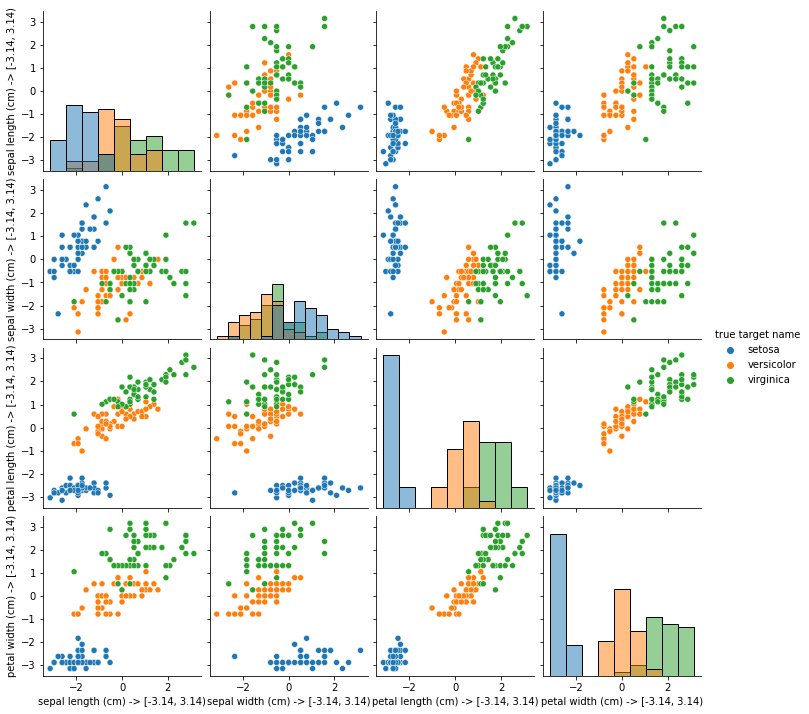

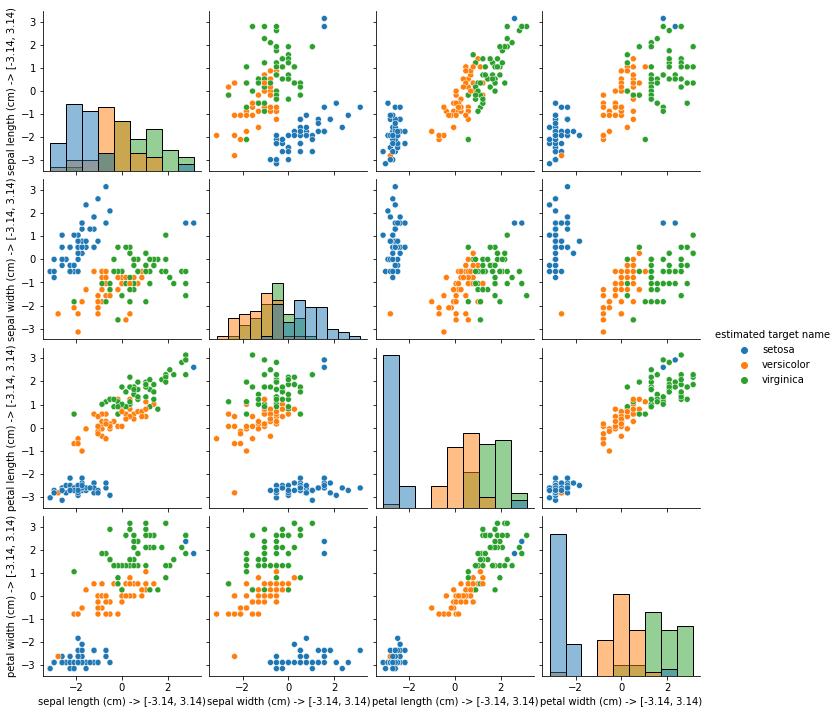

In [144]:
from seaborn import pairplot
from pandas import DataFrame

namer = lambda index, name_set : [name_set[i] for i in index]

data = dict()
for i in range(4):
    data[iris_features[i]] = iris_data[:, i]
data['true label'] = iris_label
data['estimated label'] = estimated_label
data['true target name'] = namer(iris_label, iris_names)
data['estimated target name'] = namer(estimated_label, iris_names)

pairplot(DataFrame(data=data), x_vars = iris_features, y_vars = iris_features, hue='true target name', diag_kind='hist')
pairplot(DataFrame(data=data), x_vars = iris_features, y_vars = iris_features, hue='estimated target name', diag_kind='hist')

In [153]:
sum(estimated_label==iris_label)/len(iris_label)

0.9466666666666667

In [154]:
from sklearn.svm import SVC
__qasvm = PseudoSoftQASVM(
        trainind_data, training_labels[__l], lamda=1, C=10,
        quantum_instance=quantum_instance,
        var_form=None,
        feature_map=feature_map
    )
kernel_matrix = __qasvm.kernel_matrix
svm = SVC(C=10, kernel='precomputed')
svm.fit(kernel_matrix, np.where(training_set['target'].to_numpy()==2, 1, -1))

svm_estimation = svm.predict(__qasvm._qk.evaluate(iris_data, trainind_data))


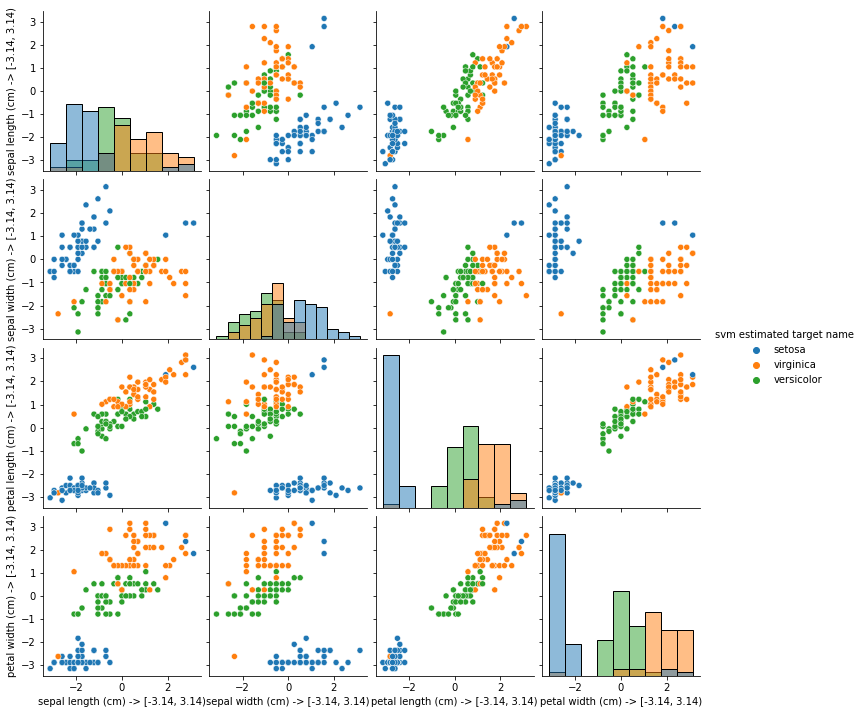

In [113]:
data['svm estimated target name'] = namer(svm_estimation, iris_names)
pairplot(DataFrame(data=data), x_vars = iris_features, y_vars = iris_features, hue='svm estimated target name', diag_kind='hist')


In [156]:
sum(svm_estimation==np.where(iris_label==2, 1, -1))/len(iris_label)

0.9466666666666667

In [158]:
sum(results['virginica']['model'].predict(iris_data)==np.where(iris_label==2, 1, 0))/len(iris_label)

0.9533333333333334

In [15]:
asdf = results['setosa']['model']
plt.plot(asdf.alpha(asdf.parameters))

TypeError: 'NoneType' object is not callable

In [ ]:
plt.plot(np.abs(svm.dual_coef_[0]))

In [115]:
qasvm1 = PseudoSoftQASVM(
        trainind_data, training_labels[__l], lamda=1, C=10,
        quantum_instance=quantum_instance,
        var_form=var_form,
        feature_map=feature_map
    )

qasvm2 = SoftQASVM(
        trainind_data, training_labels[__l], lamda=1, C=10,
        quantum_instance=quantum_instance,
        var_form=var_form,
        feature_map=feature_map
    )

random_params = np.random.rand(var_form.num_parameters)

print(qasvm1.cost_fn(random_params))
print(qasvm2.cost_fn(random_params))

0.4096180990491143
0.409618099049118


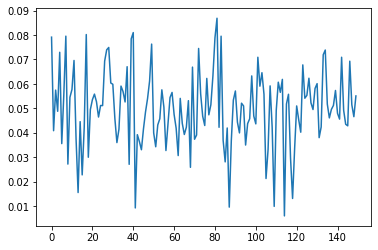

In [116]:
plt.plot(abs(predictions['setosa']))

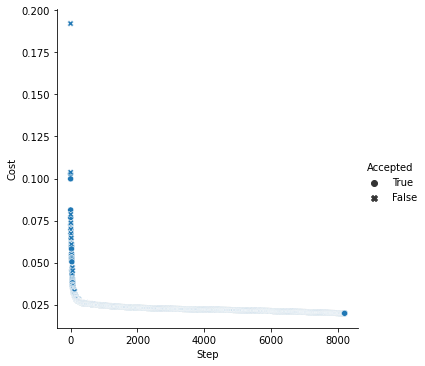

In [117]:
results[list(results.keys())[2]]['storage'].plot()

In [118]:
import dill
with open('./statevector_simulation_result', 'wb') as fp:
    dill.dump(results, fp)

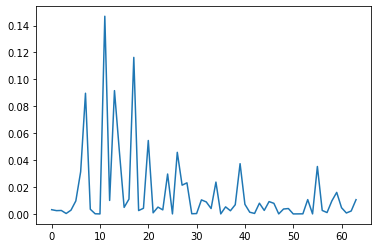

In [160]:
plt.plot(results['virginica']['model'].alpha(results['virginica']['model'].parameters))

In [171]:
from qiskit import QuantumCircuit
from qiskit.providers.aer import QasmSimulator

qc = QuantumCircuit(4)
qc.x(2)
int(list(quantum_instance.execute(qc).get_counts().keys())[0], base=2)

4

In [175]:
qasvm = results['setosa']['model']
storage = results['setosa']['storage']
qasvm.parameters

{ParameterVectorElement(θ[0]): 1.560955606431418, ParameterVectorElement(θ[1]): 0.16077252432452227, ParameterVectorElement(θ[2]): -1.2294433692205167, ParameterVectorElement(θ[3]): -0.16041645958260925, ParameterVectorElement(θ[4]): -0.5844708288115568, ParameterVectorElement(θ[5]): 3.00617111481139, ParameterVectorElement(θ[6]): 4.917085930022218, ParameterVectorElement(θ[7]): 0.13815877444224345, ParameterVectorElement(θ[8]): -0.7681906828007615, ParameterVectorElement(θ[9]): 2.8321437299249332, ParameterVectorElement(θ[10]): -1.0875489729825674, ParameterVectorElement(θ[11]): 0.389652812610914, ParameterVectorElement(θ[12]): 0.8890977877741031, ParameterVectorElement(θ[13]): 0.48026850713045943, ParameterVectorElement(θ[14]): 2.8750796853071163, ParameterVectorElement(θ[15]): -1.1844144010918731, ParameterVectorElement(θ[16]): -0.6906063458625677, ParameterVectorElement(θ[17]): -0.1387750789378503, ParameterVectorElement(θ[18]): -1.6921381109346916, ParameterVectorElement(θ[19]): -

In [182]:
qasvm.accuracy(iris_data, np.where(iris_label==0, 1, 0))

0.92

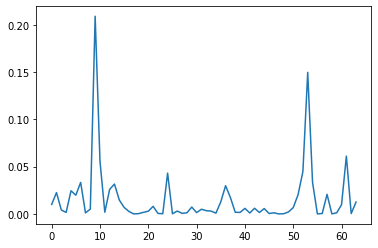

In [188]:
plt.plot(qasvm.alpha(qasvm.parameters))

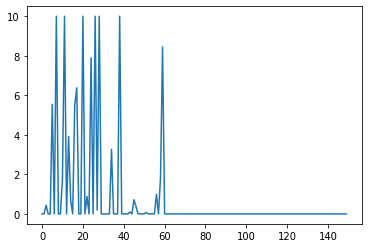

In [194]:
svm_alpha = np.zeros(len(iris_label))
svm_alpha[svm.support_] = np.abs(svm.dual_coef_)
plt.plot(svm_alpha)

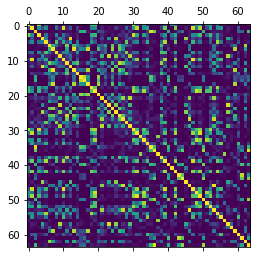

In [197]:
plt.matshow(qasvm.kernel_matrix)

In [200]:
S, v, D = np.linalg.svd(qasvm.kernel_matrix)

<BarContainer object of 64 artists>

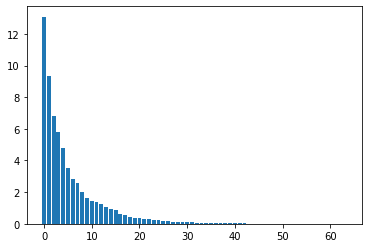

In [224]:
plt.bar(x = np.arange(len(qasvm.label)), height = v)

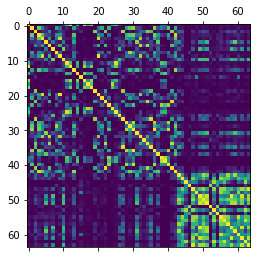

In [220]:
plt.matshow(qasvm.kernel_matrix[np.argsort(qasvm.label)].T[np.argsort(qasvm.label)].T)

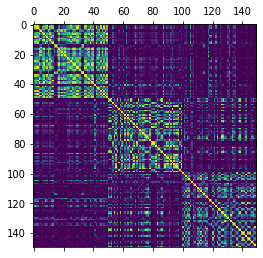

In [226]:
____kernel_matrix = __qasvm._qk.evaluate(iris_data, iris_data)
plt.matshow(____kernel_matrix)

<BarContainer object of 10 artists>

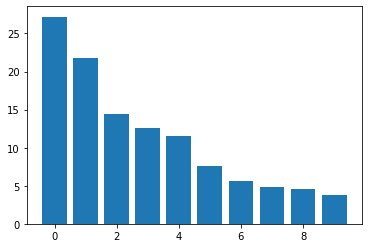

In [229]:
S, v, D = np.linalg.svd(____kernel_matrix)
plt.bar(x = np.arange(len(iris_label))[:10], height = v[:10])

In [254]:
import dill

with open('statevector_simulation_result', 'rb') as fp:
    sv_result = dill.load(fp)
with open('qasm_simulation_result', 'rb') as fp:
    qasm_result = dill.load(fp)


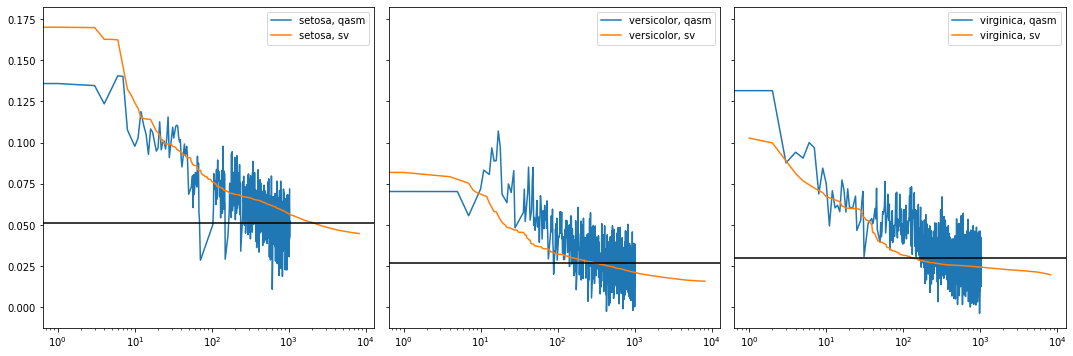

In [266]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 5))

for i, k in enumerate(sv_result.keys()):
    loss = qasm_result[k]['storage'].data['Cost']
    step = qasm_result[k]['storage'].data['Step']
    accepted = qasm_result[k]['storage'].data['Accepted']
    axes[i].plot(step[accepted], loss[accepted], label=k+', qasm')

    loss = sv_result[k]['storage'].data['Cost']
    step = sv_result[k]['storage'].data['Step']
    accepted = sv_result[k]['storage'].data['Accepted']
    axes[i].plot(step[accepted], loss[accepted], label=k+', sv')


    last_avg = qasm_result[k]['storage'].last_cost_avg(16, True)
    axes[i].axhline(last_avg, 0, 1, color='k')
    axes[i].legend()

plt.tight_layout()
plt.xscale('log')

In [253]:
for i, k in enumerate(result.keys()):
    ____qasvm = result[k]['model']
    acc = ____qasvm.accuracy(iris_data, np.where(iris_label==i, 1, 0))
    print(k, acc)

setosa 0.9733333333333334
versicolor 0.82
virginica 0.9066666666666666


In [292]:
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap
# from classifiers.convex.svm import CvxSoftQASVM
from qiskit_machine_learning.kernels import QuantumKernel

quatum_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=quantum_instance)
zz_kernel_matrix = quatum_kernel.evaluate(trainind_data, trainind_data)

zz_svm = SVC(kernel='precomputed', C=100)
zz_svm.fit(zz_kernel_matrix, training_set['target'])
zz_svm.score(quatum_kernel.evaluate(iris_data, trainind_data), iris_label)

0.9466666666666667